# EigenPortfolio Project

## 1. Overview
Finance and algorithmic trading heavily use linear algebra. In this project, we will investigate how
you can directly create a portfolio (set of allocations for companies in the market) by using the
singular value decomposition (SVD) that you learned in class. In essence, we will use the past
daily prices for over 1000 companies over a “training” period to generate right singular vectors and
normalize these singular vectors to get allocations for each of the 1000 companies over the “test”
period.
In particular, we outline below how to create these “eigen”-portfolios:
1. Import necessary packages and data.
2. Pre-process, clean up, and plot the data using pandas and matplotlib.
3. Transform the data to use company returns and normalized returns rather than close prices.
4. Split the data into a training set and a test set.
5. Compute the SVD of the training data (you will complete this portion).
6. Plot the SVD to get a sense of the market.
7. Compile the SVD into the eigen-portfolios.
8. Compute returns and cumulative returns.
9. Compute performances of portfolios with the Sharpe ratio.
10. Plot performances of best eigen-portfolios.

The only aspects of these steps that you need to actually do here will be to compute the SVD and
compile the SVD into the eigen-portfolios.

In [1]:
# import packages
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
df_path = 'close_prices.csv'

## 2. Uploading data into Google Colaboratory

To actually run this jupyter notebook, you can run jupyter notebook on your own computer if you
have it set up; however, you may also use Google colaboratory to create and run this notebook.
I’ve implemented the first method of how to import the data into google colaboratory. The details
are outlined [here](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8). If you are using Google colaboratory, uncomment the lines of code after the first
in the next cell.

In [2]:
# only uncomment the next lines if using google colaboratory (takes some time)
# import io
# from google.colab import files
# uploaded = files.upload()
# df_path = io.StringIO(uploaded['close_prices.csv']).decode('utf-8')

## 3. Data Wrangling
We clean the data here to make sure that any of the dates we use have at least 500 data points.
In particular, we get rid of dates that have too many NaN values. We also transform the dates into
pandas datetime indices to be able to easily manage data. We finally take a look at some portion
of the dataframe.

In [3]:
# import data
close_prices = pd.read_csv(df_path)
# clean data
close_prices['date'] = close_prices['date'].apply(lambda x: x.split()[0])
close_prices = close_prices.set_index(['date'])
close_prices = close_prices[~close_prices.index.duplicated(keep='first')]
close_prices = close_prices[close_prices.isnull().sum(axis=1) < 500]
dts = pd.to_datetime(close_prices.index)
close_prices.index = dts
close_prices.name = 'prices'
close_prices.head(10)

,AAIC,AAL,AAON,AAP,AAPL,AB,ABB,ABBV,ABC,ABCB,...,Y,YELL,YNDX,YPF,YUM,ZBH,ZBRA,ZD,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
1999-11-01,17.215847,NaN,0.963988,NaN,0.595872,5.832890,NaN,NaN,2.646925,5.628370,...,150.909670,108830.902945,NaN,11.167411,4.896850,NaN,11.712591,2.698182,40.477164,NaN
1999-11-02,18.253337,NaN,0.995558,NaN,0.616062,6.378645,NaN,NaN,2.621790,5.602393,...,151.699773,108438.483824,NaN,11.073691,4.821997,NaN,11.341362,2.541675,41.676538,NaN
1999-11-03,18.026386,NaN,1.009507,NaN,0.625658,6.289377,NaN,NaN,2.536717,5.576416,...,151.897299,110400.579430,NaN,11.020973,4.738693,NaN,11.142843,2.541675,41.162521,NaN
1999-11-04,18.447866,NaN,0.995558,NaN,0.641933,6.555154,NaN,NaN,2.513515,5.576416,...,150.909670,110008.160309,NaN,10.927252,4.738693,NaN,10.918517,2.579237,41.553174,NaN
1999-11-05,19.452934,NaN,1.005102,NaN,0.677937,6.620076,NaN,NaN,2.440043,5.576416,...,149.724516,109223.322067,NaN,10.836460,4.882363,NaN,10.906606,2.623059,42.622331,NaN
1999-11-08,18.836925,NaN,0.991153,NaN,0.739812,6.441539,NaN,NaN,2.453578,5.736608,...,149.724516,107195.823274,NaN,10.836460,4.896850,NaN,11.426725,2.660621,43.136348,NaN
1999-11-09,18.447866,NaN,0.963988,NaN,0.687993,6.429366,NaN,NaN,2.513515,5.628370,...,149.329464,107588.242395,NaN,10.982899,5.026033,NaN,11.426725,4.206911,42.492113,NaN
1999-11-10,17.831857,NaN,0.945633,NaN,0.701965,6.327925,NaN,NaN,2.610189,5.576416,...,147.354207,110400.579430,NaN,11.129337,5.259044,NaN,11.662962,4.307075,42.492113,NaN
1999-11-11,17.831857,NaN,0.940494,NaN,0.708183,6.175762,NaN,NaN,2.501915,5.602393,...,146.666817,111185.417673,NaN,11.038545,5.335104,NaN,11.762221,4.188130,42.409870,NaN


In [4]:
print(close_prices.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4000 entries, 1999-11-01 to 2015-09-24
Columns: 1256 entries, AAIC to ZTS
dtypes: float64(1256)
memory usage: 38.4 MB
None


## 4. Plotting functionality
Just to get a visual idea of the data, we plot the prices for a particular symbol. We will finally plot
this for the asset returns later on as well. Take a look at the plot for AAPL.

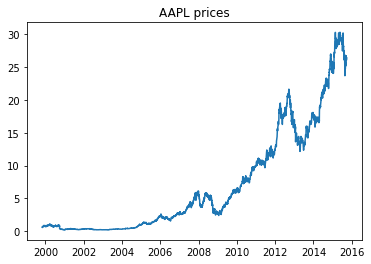

In [5]:
# plotting function
def plot_symbol(symbol, df, csum=False):
# csum denotes cummulative summation (useful for returns)
    yvals = df[symbol]
    if csum: yvals = np.cumsum(yvals)
    plt.plot(df.index, yvals)
    title = symbol + ' ' + df.name
    plt.title(title)
    
# check price chart for
plot_symbol('AAPL', close_prices)

## 5. Asset Returns Transform
We calculate the returns by the day-to-day percent change of an asset. Once we have the returns,
we normalize them by normalizing each individual asset’s mean and standard deviation. Why
would we want to normalize the returns in this manner?

In [6]:
# calculate the percent change of each asset (pandas as an easy way to do this....)
returns = close_prices.pct_change().dropna(axis=0, how='all')
normed_returns = (returns - returns.mean())/returns.std()
normed_returns = normed_returns.dropna(axis=0, how='all')
returns.name = 'returns'
normed_returns.name = 'normalized returns'

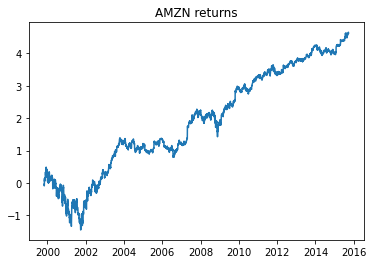

In [7]:
# plot returns
plot_symbol('AMZN', returns, csum=True)

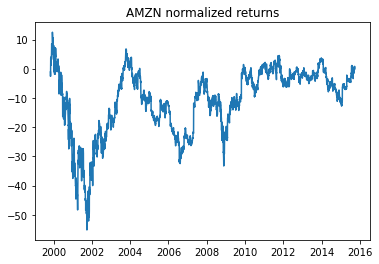

In [8]:
# plot normalized returns
plot_symbol('AMZN', normed_returns, csum=True)

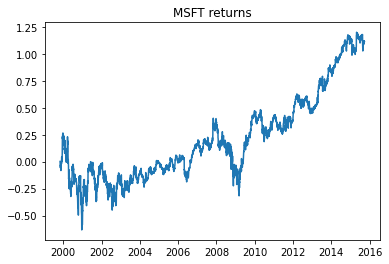

In [9]:
plot_symbol('MSFT', returns, csum=True)

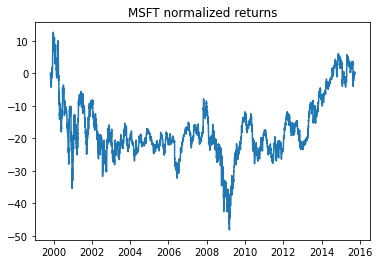

In [10]:
plot_symbol('MSFT', normed_returns, csum=True)

## 6 Data Preparation
In this section, we create a training and test data set.

In [11]:
# use datetime cut-off for training vs test data set
train_end = datetime.datetime(2014, 9, 24)
# get training data for normed returns
df_train = normed_returns[normed_returns.index <= train_end].copy().dropna(axis=1, how='any')
# get test data for normed returns
df_test = normed_returns[normed_returns.index > train_end].copy().dropna(axis=1, how='any')
df_test = df_test[df_train.columns] # retain same tickers in test data as in training

# get training data for regular returns
df_raw_train = returns[returns.index <= train_end].copy().dropna(axis=1,how='any')
# get test data for regular returns
df_raw_test = returns[returns.index > train_end].copy().dropna(axis=1,how='any')
df_raw_test = df_raw_test[df_train.columns] # retain same tickers in test data as in training

print('Train dataset:', df_train.shape)
print('Test dataset:', df_test.shape)

Train dataset: (3747, 1073)
Test dataset: (252, 1073)


## 7. Computing SVD of training data

Consider our training data matrix as an $T \times N$ matrix $X$ with $N$ samples (our tickers) and $T$ variables (our dates). If we assume that $X$ is normalized as we have done above, we can calculate the empirical correlation matrix of our data by

$$C = \frac{1}{T-1}X^TX \in \mathbb{R}^{N\times N}$$

with eigendecomposition $C = VLV^T$. The eigenvectors of $C$ should tell us how the stocks correlate to each other. Notice, however, that the eigenvectors $V$ of $C$ are just the right singular vectors of $X = U\Sigma V^T$. This means that we only need to compute the SVD of our data to be able to investigate the correlation of the stocks. Let’s calculate the SVD using [numpy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html). Call the right singular vectors `v` for `df_train` and `v_raw` for `df_raw_train`.

After gathering the singular vectors, we proceed to create a scatter plot of the singular vectors. Try to plot different singular vectors and comment on the behavior of the singular vectors for the normalized vs raw return SVDs.

**Definition:**
Let $V$, $W$ be inner product spaces, and $T\in \mathcal{L}(V,W)$ is any linear map. A map $\mathcal{S}\in \mathcal{L}(W,V)$ is called the adjoint of $T$ if $\langle Tv, w \rangle = \langle v, Sw \rangle$. And we write $S=T^*$.

For example, if matrix $A\in \mathbb{R}^{n\times n}$, then we have

$$
\begin{aligned}
\langle Ax, y \rangle &= y^TAx\\
&= y^T(A^T)^Tx\\
&= (A^Ty)^Tx\\
&= \langle x, A^Ty \rangle\\
\end{aligned}
$$

In this case, $C\in \mathbb{R}^{N\times N}$ is the empirical correlation matrix. With its symmetry $C^T = C$, it is self-adjoint.


**Spectral Theorem:**
- If $T \in \mathcal{L}(V)$ is a self-adjoint linear map, then $V$ has an orhtonormal basis consist of eigenvectors of $T$.
- $A\in \mathbb{R}^{n\times n}$ symmetric. Then A is orthogonally diagonalizable. Namely, there exists an orthogonal matrix $U$ and a diagonal matrix 
$D=
\begin{pmatrix}
  \lambda_1 & {} & {} & {}\\
  {} & \lambda_2 & {} & {} \\
  {} & {} & \ddots & {} \\
  {} & {} & {} & \lambda_n
\end{pmatrix}
$
such that $A = UDU^{-1} = UDU^T$

$C = VLV^T$ where $V$ is the matrix of normalilzed eigenvectors. $\lambda = \sigma^2$

$\begin{aligned}
C &= \frac{1}{T-1}X^TX\\
&= \frac{1}{T-1}(U\Sigma^TV)^T(U\Sigma V^T)\\
&= \frac{1}{T-1}(V\Sigma^T U^TU\Sigma V^T)\\
&= \frac{1}{T-1}(V\Sigma^T \Sigma V^T)\\
&= V\frac{\Sigma^T \Sigma}{T-1}V^T\\
&= VLV^T
\end{aligned}$

And $L = \frac{1}{T-1}
\begin{pmatrix}
  \lambda_1 & {} & {} & {}\\
  {} & \lambda_2 & {} & {} \\
  {} & {} & \ddots & {} \\
  {} & {} & {} & \lambda_n
\end{pmatrix}
$

In [12]:
# C is a 1073 x 1073 correlation matrix
X = df_train.values
X_raw = df_raw_train.values

# calculate SVD here
# np.linalg.svd returns the transpose of V
U, S, v = np.linalg.svd(X)
U_raw, S_raw, v_raw = np.linalg.svd(X_raw)

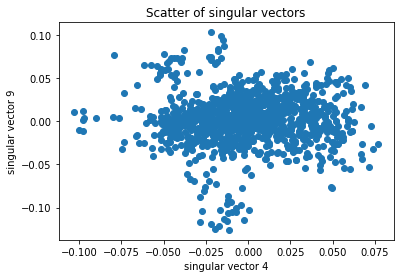

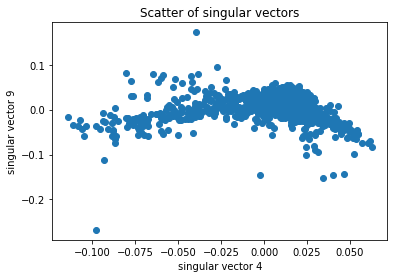

In [13]:
# plot the 
# Explore the structure within the data
# Each singular vecotr in 2 D space (projections)
# Each dot on the plot is a sticker.
def scatter_plot_svd(v, i1=1, i2=2):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(v[i1,:], v[i2,:])
    title = 'Scatter of singular vectors'
    ax.set_title(title)
    ax.set_xlabel('singular vector '+str(i1))
    ax.set_ylabel('singular vector '+str(i2))
    
scatter_plot_svd(v, 4, 9)
scatter_plot_svd(v_raw, 4, 9)

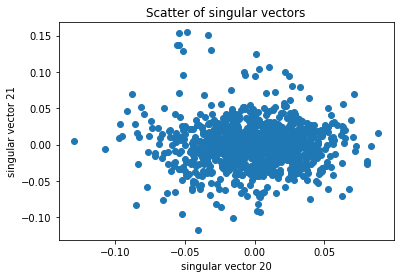

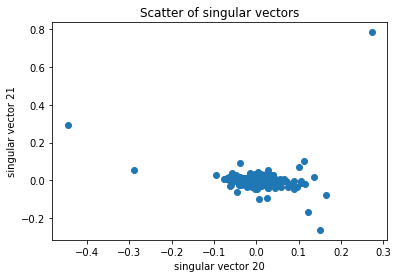

In [14]:
scatter_plot_svd(v, 20, 21)
scatter_plot_svd(v_raw, 20, 21)

## 8. Generate portfolios by normalizing

We will define the $j$th eigenportfolio $Q^{(j)}$ by simply the normalized $j$th right singular vector $v^{(j)}$ so that the resultant $Q^{(j)}$ sums to 1. In particular, compute

$$Q^{(j)} = \frac{1}{\sum_{k=1}^N v_k^{(j)}} v^{(j)}$$

We do this in the function below and compile the portfolios into a single pandas dataframe.

In [15]:
# function to get all eigenportfolios up to jmax
# Each singular vector you got an eigenPortfolio
def j_eigPortfolio(s_vecs, tickers=df_train.columns):
    # make empty portfolio list
    portfolios = []
    for j in range(len(tickers)):
        # normalize singular vector to sum to 1
        # calculate the jth eigenportfolio and call it j_port
        j_port = s_vecs[j]/np.sum(s_vecs[j,:])
        j_port = pd.DataFrame(j_port,index=tickers, columns=['Q_'+str(j+1)])
        portfolios.append(j_port)
    portfolios = pd.concat(portfolios, axis=1)
    return portfolios

portfolios_svd = j_eigPortfolio(v) # SVD portfolio computed from normalized returns
portfolios_svd_raw = j_eigPortfolio(v_raw) # SVD portfolio computed from raw returns

In [16]:
# view data
display(portfolios_svd_raw.head(10))
display(portfolios_svd.head(10))

,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_1064,Q_1065,Q_1066,Q_1067,Q_1068,Q_1069,Q_1070,Q_1071,Q_1072,Q_1073
AAIC,0.001680,0.006791,-0.005605,-0.004373,0.008490,-0.013861,-0.026036,0.321520,5.287515,-0.007419,...,0.087886,-0.045367,0.506298,0.036211,0.197511,0.058663,-0.029303,0.001259,0.080697,-0.063569
AAON,0.000998,0.005098,0.000990,-0.007519,0.005757,-0.008419,0.003069,0.102075,2.265475,0.003815,...,-0.204599,0.436113,1.969726,-0.133500,-0.009517,0.022429,-0.088887,0.090013,-0.051357,0.047134
AAPL,0.000897,0.005534,0.000963,-0.005424,-0.022579,0.000186,0.008870,-0.046476,-1.765839,-0.002053,...,0.186630,-0.128818,-0.941889,-0.001996,0.281900,0.248974,-0.196759,-0.310936,-0.552310,-0.109156
AB,0.001120,0.007951,-0.000712,-0.000002,0.005648,-0.006837,-0.017325,-0.046924,-1.115297,-0.004185,...,0.728807,0.124025,1.126012,0.093953,-0.143926,-0.337716,-0.190295,-0.921655,-0.252925,-0.027090
ABC,0.000490,0.010355,-0.002882,0.001852,0.002460,0.000924,0.005171,-0.084748,0.491095,0.011815,...,0.072781,0.015744,0.399819,-0.122961,-0.545740,-0.120745,0.035381,1.262396,1.680129,-0.026275
ABCB,0.001283,0.008977,-0.004340,-0.001490,0.021949,-0.020366,-0.042097,0.093879,3.209758,-0.001036,...,-0.411860,-0.443741,-2.695901,-0.209864,-0.006153,0.086678,0.116209,0.228727,-0.310349,-0.076843
ABEV,0.000642,0.005053,0.000413,0.002142,0.008668,0.016684,0.041873,-0.018195,-0.592915,-0.000631,...,0.286281,-0.103620,1.074144,-0.111913,0.193347,0.204103,0.114672,0.275256,-0.705584,0.238827
ABIO,0.000873,0.011491,0.017207,0.001515,-0.041788,0.013408,0.006316,0.112287,16.843743,0.013699,...,0.104194,-0.008375,-0.262409,-0.000156,-0.062961,0.043780,-0.000259,-0.060231,-0.057304,0.005470
ABM,0.000852,0.000508,-0.000361,0.002642,0.004187,-0.005465,-0.010340,0.019721,1.038481,0.005829,...,0.149413,-0.144679,-3.651623,-0.078086,0.121992,-0.081832,-0.413100,-0.751695,-0.166740,0.016944
ABMD,0.001068,0.017214,0.001355,0.012386,-0.014966,-0.004158,-0.019399,0.088884,4.477438,0.006511,...,0.296563,0.244259,0.206449,-0.031024,0.020602,-0.166721,0.074259,-0.377328,-0.044060,0.081550


,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,Q_9,Q_10,...,Q_1064,Q_1065,Q_1066,Q_1067,Q_1068,Q_1069,Q_1070,Q_1071,Q_1072,Q_1073
AAIC,0.000869,-0.002110,-0.011231,-0.039571,0.018026,-0.032980,-0.014841,0.004586,-0.011438,-0.009146,...,0.288421,-5.450965,-0.384220,0.319579,-0.210748,0.034712,-0.110935,0.049508,-0.368698,0.116434
AAON,0.000986,-0.001087,-0.009540,-0.021038,0.020908,0.077128,0.031736,0.000100,-0.004756,-0.001349,...,0.144197,4.192278,0.713856,-0.056304,0.032624,-0.145236,-0.427404,-0.005721,-0.064912,-0.009841
AAPL,0.000822,0.021252,-0.002387,-0.014092,0.003918,-0.055220,-0.037208,-0.002334,-0.021707,-0.013464,...,0.235998,-1.273494,0.946898,-0.000415,-0.027110,0.018204,-0.338604,-0.155937,0.144396,0.181516
AB,0.001232,-0.000710,-0.008048,-0.022987,-0.017994,-0.065367,0.008990,-0.003866,0.020271,0.016062,...,-0.146031,-2.633144,0.190360,-0.421815,-0.045143,-0.156583,-0.155134,0.091400,0.286851,0.217888
ABC,0.000711,-0.001175,0.010994,0.155579,0.002968,0.008083,0.016982,0.024506,0.038724,-0.015596,...,-0.116903,3.462458,0.551698,0.001106,-0.644872,-0.146912,-0.608966,0.013358,0.448274,-0.125455
ABCB,0.001107,-0.012768,-0.020011,-0.029253,0.024680,0.013709,0.041800,-0.002010,-0.017206,-0.009567,...,0.348618,-6.314667,1.329272,0.037668,-0.111948,-0.061743,0.450718,-0.252386,0.654910,-0.177528
ABEV,0.000745,-0.004757,0.020183,-0.046637,-0.002984,-0.030452,-0.047121,0.011433,-0.009518,0.014774,...,0.090270,4.581093,0.168387,-0.181962,0.031994,-0.002936,-0.298518,0.013684,0.028694,-0.022803
ABIO,0.000266,0.010099,0.000901,-0.009887,0.007283,-0.012889,0.012250,0.013663,0.027030,0.002073,...,0.093813,-2.027440,-0.338905,0.179307,0.066708,0.062579,0.634603,0.010964,0.339782,-0.000129
ABM,0.001114,-0.000279,-0.006700,0.026754,0.020729,0.070815,0.028910,0.001963,0.000521,0.001935,...,0.074941,-8.135964,0.937096,-0.366723,-0.311300,-0.115213,-0.602852,-0.177337,0.367904,0.159485
ABMD,0.000687,0.009123,-0.004855,-0.007072,0.018357,-0.016268,0.039279,0.011799,0.030670,-0.001362,...,-0.047342,0.601971,0.383810,-0.512818,-0.225420,-0.069057,-0.270876,0.083645,-0.096346,0.031375


## 9 Compute performance of eigenportfolios

### 9.1 Compute returns and cumulative returns
We will simply compute the dot product of each eigenportfolio weight with how each stock performed for the test data. This is easily done by using `.dot` for a pandas dataframe. Afterwards,we can compute the cumulative returns by just using the pandas function `.cumsum()`. We will consider 3 portfolio performances:

1. normalized returns training data portfolio performance on the normalized returns test data.
2. raw returns training data portfolio performance on the raw returns test data.
3. normalized returns training data portfolio performance on the raw returns test data.

In [17]:
# use df.dot from pandas to do this
# SVD returns
svd_rets = df_test.dot(portfolios_svd) # norm_return train vs norm_return
svd_rets_raw = df_raw_test.dot(portfolios_svd_raw) # raw_return train vs raw_return test
svd_rets_prime = df_raw_test.dot(portfolios_svd) # norm_return train vs raw_return test

# SVD cumulative returns
c_svd_rets = svd_rets.cumsum()
c_svd_rets_raw = svd_rets_raw.cumsum()
c_svd_rets_prime = svd_rets_prime.cumsum()

### 9.2 Performance metrics with Sharpe Ratio
When looking for a good investment, we want **positive** steady returns. We can think of the positive returns aspect as a positive average return whilst the **steady** returns aspect can be thought of as having low variance in the returns. This idea gives rise to the Sharpe ratio $\frac{\mu}{\sigma}$, a common method to measure the profitability of a trading strategy, which is essentially the mean
divided by the standard deviation.

- A high Sharpe ratio indicates high average returns with low variance (i.e. steady returns).

- A low (but positive) Sharpe ratio means positive returns but risky.

- A negative Sharpe ratio means negative returns.

We will calculate the Sharpe ratios of all the portfolios and order them by the best performing
ones.

In [18]:
# sharpe ratio calculations
def sharpe_ratio(ts_returns):
    """
    sharpe_ratio - Calculates annualized return, annualized vol, and annualized sharpe ratio,
    where sharpe ratio is defined as annualized return divided by annualized volatility 
    Arguments: ts_returns - pd.Series of returns of a single eigen portfolio
    """
    annualized_return = 0.
    annualized_vol = 0.
    annualized_sharpe = 0.
    
    n_years = ts_returns.shape[0]
    ret = ts_returns.mean()
    ret.name = 'mean returns'
    tot_rets = ts_returns.sum()
    tot_rets.name = 'cumulative returns'
    vol = ts_returns.std()
    vol.name = 'vol'
    sharpe = ret / vol
    sharpe.name = 'sharpe'
    out_df = pd.concat([ret, tot_rets ,vol,sharpe],axis=1)
    
    return out_df

# svd sharpe ratios
svd_sharpe = sharpe_ratio(svd_rets).sort_values(by=['sharpe'], ascending=False)
svd_raw_sharpe = sharpe_ratio(svd_rets_raw).sort_values(by=['sharpe'],ascending=False)
svd_prime_sharpe = sharpe_ratio(svd_rets_prime).sort_values(by=['sharpe'],ascending=False)

Take a look at the top 5 performing portfolios from each section.

In [19]:
print('SVD sharpe')
display(svd_sharpe.head(5))
print('SVD raw sharpe')
display(svd_raw_sharpe.head(5))
print('SVD prime sharpe')
display(svd_prime_sharpe.head(5))

SVD sharpe


,mean returns,cumulative returns,vol,sharpe
Q_575,0.931256,234.676474,4.426585,0.210378
Q_258,7.585107,1911.446935,40.923444,0.185349
Q_584,1.086480,273.792896,6.179419,0.175822
Q_912,23.813802,6001.078013,136.912758,0.173934
Q_514,0.471488,118.814931,3.036164,0.155291


SVD raw sharpe


,mean returns,cumulative returns,vol,sharpe
Q_1020,0.049062,12.363619,0.214973,0.228224
Q_644,0.189340,47.713793,0.898191,0.210802
Q_300,0.019358,4.878180,0.096674,0.200238
Q_872,0.022231,5.602189,0.111524,0.199337
Q_909,0.042788,10.782517,0.231836,0.184560


SVD prime sharpe


,mean returns,cumulative returns,vol,sharpe
Q_258,0.252665,63.671689,1.430187,0.176666
Q_1051,0.082910,20.893412,0.481511,0.172188
Q_575,0.022128,5.576288,0.130323,0.169795
Q_584,0.030289,7.632936,0.184086,0.164539
Q_215,0.005808,1.463616,0.035419,0.163982


### 9.3 Plotting top portfolios

Here we plot the top portfolios of each configuration.

In [20]:
def plot_performance(c_rets, indices, title='PCA'):
    fig = plt.figure(figsize=(13,7))
    ax0 = fig.add_subplot(111)
    ax0.plot(c_rets[indices])
    title = title+': Portfolio performance'
    ax0.set_title(title)
    ax0.legend(indices)

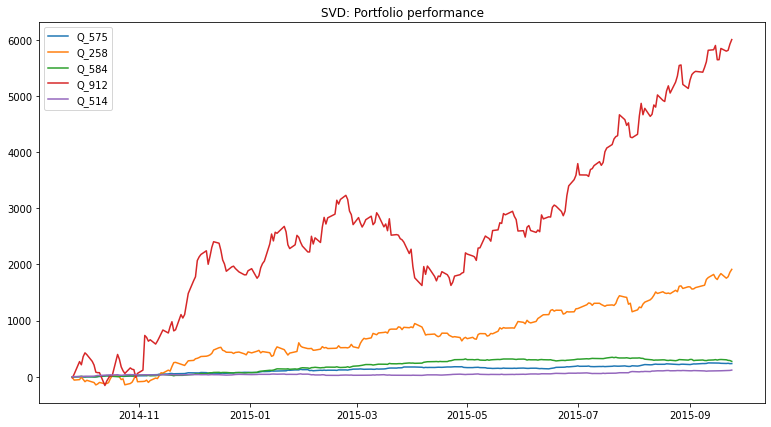

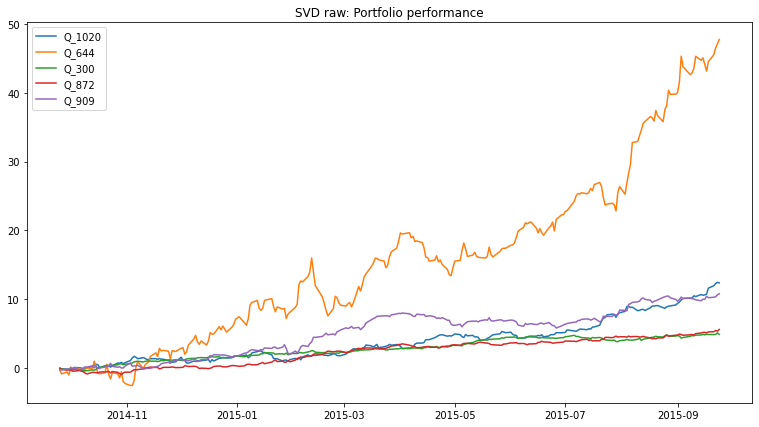

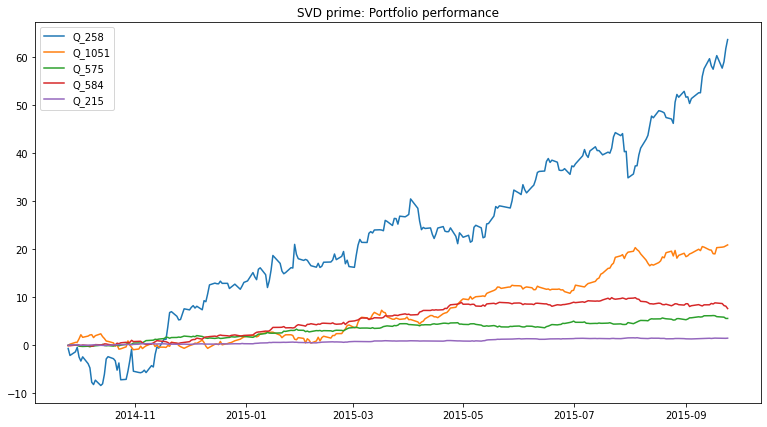

In [21]:
plot_performance(c_svd_rets, svd_sharpe.head(5).index, title='SVD')
plot_performance(c_svd_rets_raw, svd_raw_sharpe.head(5).index, title='SVD raw')
plot_performance(c_svd_rets_prime, svd_prime_sharpe.head(5).index, title='SVD prime')